In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score

In [ ]:
def read_csv_from_link(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    df = pd.read_csv(path,delimiter="\t",error_bad_lines=False, header=None)
    return df

In [2]:
# Data and Label Mapping
kannada_train = read_csv_from_link('https://drive.google.com/file/d/1BFYF05rx-DK9Eb5hgoIgd6EcB8zOI-zu/view?usp=sharing')
kannada_dev = read_csv_from_link('https://drive.google.com/file/d/1V077dMQvscqpUmcWTcFHqRa_vTy-bQ4H/view?usp=sharing')

# kannada Preprocess
kannada_train = kannada_train.iloc[:, 0:2]
kannada_train = kannada_train.rename(columns={0: "text", 1: "label"})
# Stats
kannada_train['label'] = pd.Categorical(kannada_train.label)
# kannada Preprocess
kannada_dev = kannada_dev.iloc[:, 0:2]
kannada_dev = kannada_dev.rename(columns={0: "text", 1: "label"})
# Stats
kannada_dev['label'] = pd.Categorical(kannada_dev.label)

label_mapping = {
    'Not_offensive': 0, 
    'not-Kannada': 1, 
    'Offensive_Targeted_Insult_Other': 2, 
    'Offensive_Targeted_Insult_Group': 3, 
    'Offensive_Untargetede': 4, 
    'Offensive_Targeted_Insult_Individual': 5
}

dev_batch_labels =  [label_mapping[x] for x in kannada_dev['label']]
target_names = label_mapping.keys()

In [3]:
import os
load_model_filenames = [x for x in os.listdir('./dev_preds/')]

In [4]:
# Read ALL fusion predictions models
load_model_filenames

['fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannadaMbert_base_cased_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_.npy',
 'fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_custom_pretrained_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_base_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannadaMURIL_cased_temp_kannada_cnn_128.npy',
 'fusion_kannada_XLMroberta_base_kannadaIndic_bert_kannada_.npy']

In [7]:
all_dev_preds = []
all_dev_model_names = []
for modelname in load_model_filenames:
    if("ipynb" not in modelname):
        all_dev_model_names.append(modelname)
        all_dev_preds.append(np.load('./dev_preds/' + modelname))

In [8]:
# Collecting Text and Labels
dev_batch_sentences = list(kannada_dev['text'])
dev_batch_labels =  [label_mapping[x] for x in kannada_dev['label']]

for dev_preds, mn in zip(all_dev_preds, all_dev_model_names):
    final_dev_preds = np.argmax(dev_preds, axis = 1)
    y_true = dev_batch_labels
    y_pred = final_dev_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannadaMbert_base_cased_kannada_cnn_128.npy
                                      precision    recall  f1-score   support

                       Not_offensive       0.80      0.79      0.79       426
                         not-Kannada       0.73      0.86      0.79       191
     Offensive_Targeted_Insult_Other       0.33      0.19      0.24        16
     Offensive_Targeted_Insult_Group       0.35      0.36      0.35        45
               Offensive_Untargetede       0.40      0.12      0.19        33
Offensive_Targeted_Insult_Individual       0.56      0.56      0.56        66

                            accuracy                           0.72       777
                           macro avg       0.53      0.48      0.49       777
                        weighted avg       0.71      0.72      0.71       777

fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_cnn_128.npy
                               

In [ ]:
# Averaging Ensemble

In [9]:
all_dev_preds = np.array(all_dev_preds)
# Initialise Weights
w = np.ones(all_dev_preds.shape[0])
softmax_w = np.exp(w)/np.sum(np.exp(w))

weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)
print(report)

                                      precision    recall  f1-score   support

                       Not_offensive       0.81      0.81      0.81       426
                         not-Kannada       0.74      0.85      0.79       191
     Offensive_Targeted_Insult_Other       0.50      0.06      0.11        16
     Offensive_Targeted_Insult_Group       0.39      0.40      0.40        45
               Offensive_Untargetede       0.22      0.18      0.20        33
Offensive_Targeted_Insult_Individual       0.66      0.59      0.62        66

                            accuracy                           0.73       777
                           macro avg       0.55      0.48      0.49       777
                        weighted avg       0.72      0.73      0.72       777



In [ ]:
# GA-weighted ensemble

 The best solution found:                                                                           
 [4.03997823 1.83412154 2.04013947 2.05531012 0.02925574 1.55985391
 4.24512147 2.06835945]

 Objective function:
 0.48640022361799196


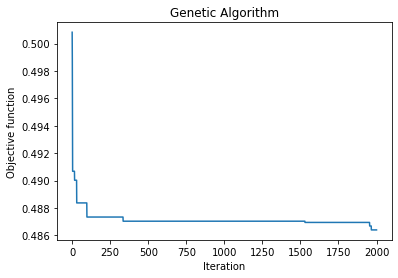

In [10]:
from geneticalgorithm import geneticalgorithm as ga

def f(X):
    softmax_w = np.exp(X)/np.sum(np.exp(X))
    weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
    weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
    final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

    y_true = dev_batch_labels
    y_pred = final_dev_preds
    score = f1_score(y_true, y_pred, average='macro')
    return 1-score

varbound=np.array([[0, 5]]*all_dev_preds.shape[0])

model=ga(function=f,dimension=all_dev_preds.shape[0],variable_type='real',variable_boundaries=varbound)

model.run()

In [11]:
convergence=model.report
solution=model.output_dict

X = solution['variable']
softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

y_true = dev_batch_labels
y_pred = final_dev_preds
target_names = label_mapping.keys()
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)
f1_score(y_true, y_pred, average='macro')

                                      precision    recall  f1-score   support

                       Not_offensive       0.81      0.81      0.81       426
                         not-Kannada       0.75      0.85      0.80       191
     Offensive_Targeted_Insult_Other       0.50      0.12      0.20        16
     Offensive_Targeted_Insult_Group       0.44      0.44      0.44        45
               Offensive_Untargetede       0.21      0.18      0.19        33
Offensive_Targeted_Insult_Individual       0.65      0.62      0.64        66

                            accuracy                           0.74       777
                           macro avg       0.56      0.50      0.51       777
                        weighted avg       0.73      0.74      0.73       777



0.513599776382008

In [12]:
model_pretrained_keys = ['']*8  # NOT REQUIRED

In [13]:
saved_model_filename = 'self_ensemble_kannada'

a = {x:(y,z) for x, y, z in zip(load_model_filenames, np.array(solution['variable']), model_pretrained_keys)}
import pickle
with open("/home/punyajoy/Dravidian_Offensive_Classification/dev_preds/weights_" + saved_model_filename + ".pickle", 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Test with Labels
tamil_test = read_csv_from_link('https://drive.google.com/file/d/10RHrqXvIKMdnvN_tVJa_FAm41zaeC8WN/view?usp=sharing')
malayalam_test = read_csv_from_link('https://drive.google.com/file/d/1zx1wCC9A-Pp80mzbqixb52WlWQQ7ATyJ/view?usp=sharing')
kannada_test = read_csv_from_link('https://drive.google.com/file/d/1Px2CvIkLP_xaNhz_fCofW-7GGBCnSYsa/view?usp=sharing')

# Kannada Preprocess
kannada_test = kannada_test.iloc[:, 0:2]
kannada_test = kannada_test.rename(columns={0: "text", 1: "label"})

b'Skipping line 778: expected 2 fields, saw 3\n'


In [10]:
kannada_test.shape

(777, 2)

In [18]:
kannada_dev.shape

(777, 2)

In [17]:
import pickle
saved_model_filename = 'self_ensemble_kannada'

with open("/home/punyajoy/Dravidian_Offensive_Classification/dev_preds/weights_" + saved_model_filename + ".pickle", 'rb') as handle:
    mw = pickle.load(handle)

In [12]:
import os
load_model_filenames = [x for x in os.listdir('/home/punyajoy/Dravidian_Offensive_Classification/finetuning/kannada_ft/dev_preds/')]

In [19]:
all_test_preds = []
all_model_names = []
for modelname in load_model_filenames:
    if("ipynb" not in modelname):
        a = np.load('/home/punyajoy/Dravidian_Offensive_Classification/finetuning/kannada_ft/test_preds/' + modelname)
        all_test_preds.append(a[:-1])
        all_model_names.append(modelname)
        print(a.shape,modelname)

(778, 6) fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannadaMbert_base_cased_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_.npy
(778, 6) fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_custom_pretrained_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_base_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannadaMURIL_cased_temp_kannada_cnn_128.npy
(778, 6) fusion_kannada_XLMroberta_base_kannadaIndic_bert_kannada_.npy


In [20]:
len(all_test_preds[0])

777

In [22]:
# Collecting Text and Labels
test_batch_sentences = list(kannada_test['text'])
test_batch_labels =  [label_mapping[x] for x in kannada_test['label']]

for test_preds, mn in zip(all_test_preds, all_model_names):
    final_test_preds = np.argmax(test_preds, axis = 1)
    y_true = test_batch_labels
    y_pred = final_test_preds
    target_names = label_mapping.keys()
    report = classification_report(y_true, y_pred, target_names=target_names)
    print(mn)
    print(report)

fusion_kannada_XLMroberta_base_kannadaXLMroberta_custom_pretrained_kannadaMbert_base_cased_kannada_cnn_128.npy
                                      precision    recall  f1-score   support

                       Not_offensive       0.80      0.80      0.80       426
                         not-Kannada       0.73      0.89      0.80       185
     Offensive_Targeted_Insult_Other       0.11      0.07      0.09        14
     Offensive_Targeted_Insult_Group       0.38      0.30      0.33        44
               Offensive_Untargetede       0.09      0.03      0.05        33
Offensive_Targeted_Insult_Individual       0.66      0.65      0.66        75

                            accuracy                           0.73       777
                           macro avg       0.46      0.46      0.45       777
                        weighted avg       0.71      0.73      0.72       777

fusion_kannada_XLMroberta_base_kannadaMbert_base_cased_kannada_cnn_128.npy
                               

/home/punyajoy/.conda/envs/nlp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# GENERATE FINAL ENSEMBLED PREDICTIONS

In [35]:
weights = [mw[index][0] for index in mw.keys()]
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

X = weights
all_dev_preds = np.array(all_dev_preds)

softmax_w = np.exp(X)/np.sum(np.exp(X))
weighted_all_dev_preds = np.array([sw*dpreds for sw, dpreds in zip(softmax_w, all_dev_preds)])
weighted_dev_preds = np.sum(weighted_all_dev_preds, axis = 0)
final_dev_preds = np.argmax(weighted_dev_preds, axis = 1)

final_dev_pred_labels = [inverse_label_mapping[int(k)] for k in final_dev_preds]
saved_model_filename = 'test_GA_fusion_kannada'
kannada_test['labels'] = final_dev_pred_labels
kannada_test.index.name = 'id'
kannada_test.to_csv("/home/punyajoy/Dravidian_Offensive_Classification/test_preds/" + saved_model_filename + ".tsv", sep = '\t')

In [36]:
np.save("/home/punyajoy/Dravidian_Offensive_Classification/model_prediction_probs/"+'GA_fusion_kannada'+".npy", weighted_dev_preds)